# Reddit Sentiment Analysis (With Vs. Without Transformer)

In this project, we will build a real-time sentiment analysis tool that collects live data from Reddit and analyzes the emotional tone of discussions using modern AI techniques. We will also compare the use of a regular AI model ('TextBlob') and an advanced AI model ('RoBERTa').

## Tech Stack

* **Data Collection**: Reddit API (PRAW)
* **AI/ML**: TextBlob, Hugging Face Transformers (RoBERTa)
* **Visualization**: Plotly, Matplotlib, WordCloud
* **Development**: Jupyter Notebook 

## Step 1: Install the Required Packages

This project will done be using the following packages -

* **praw** = Reddit API access
* **pandas** = Data manipulation and analysis
* **plotly** = Interactive visualizations
* **textblob** = Basic sentiment analysis
* **transformers** = Advanced AI models
* **matplotlib/seaborn** = Static plotting
* **wordcloud** = Word cloud generation

In [ ]:
# Install the required packages using 'pip'

pip install praw pandas plotly textblob wordcloud matplotlib seaborn transformers

## Step 2: Import the Libraries into the Kernel

* `%matplotlib inline` displays plots directly in notebook
* `warnings.filterwarnings('ignore')` cleans up output

In [4]:
# Import Libraries

import praw
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set up plotting

plt.style.use('default')
%matplotlib inline

## Step 3: Set Up Your Reddit API Credentials (Please skip this step if already done)

If you don't have your Reddit API credentials yet, here's how to set it up -

1. Go to https://www.reddit.com/prefs/apps
2. Click "Create App" → Add the App name ("Sentiment Analyzer"), description ("Sentiment Analysis Tool"), and redirect uri ("http://localhost:8080") → Choose "script" type
3. Copy your Client ID (available right below "personal use script") and Client Secret (available next to "Secret")

**Please Note**: There may be a usage quota of 100 queries per minute (QPM) when using the Reddit API. Please make sure you do not exceed the limit. 

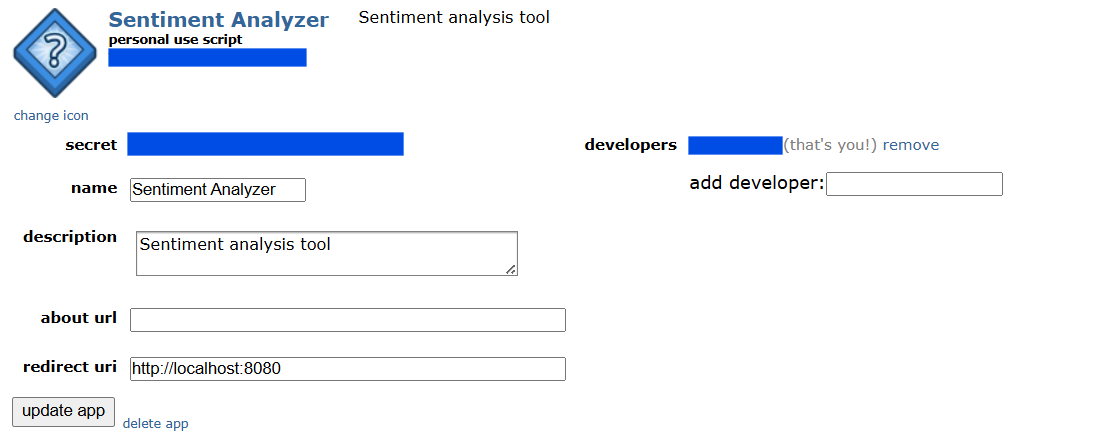

## Step 4: Configuration and Credentials

Replace 'CLIENT_ID' and 'CLIENT_SECRET' with your credentials.

In [5]:
# Configuration and Credentials


REDDIT_CONFIG = {
    'client_id': 'CLIENT_ID',           # Replace with your Client ID
    'client_secret': 'CLIENT_SECRET',   # Replace with your Client Secret  
    'user_agent': 'SentimentAnalyzer/1.0'        # Keep this as is
}


Input other settings, including -
* The subreddit topic that you want to analyze
* The number of posts you want to gather (maximum is 100 in the free version)
* The time when the posts where created
* The usage of regular AI models ('TextBlob') or advanced AI models ('RoBERTa')

In [54]:
# Analysis settings - you can modify these
ANALYSIS_CONFIG = {
    'subreddit': 'openai',     # Change to any subreddit you want
    'post_limit': 100,             # Number of posts to analyze
    'time_filter': 'new',          # 'new', 'hot', or 'top'
    'use_advanced_ai': False       # Set to True for transformer model (slower but more accurate)
}

print("✅ Configuration loaded!")
print(f"Target subreddit: r/{ANALYSIS_CONFIG['subreddit']}")
print(f"Posts to analyze: {ANALYSIS_CONFIG['post_limit']}")

✅ Configuration loaded!
Target subreddit: r/openai
Posts to analyze: 100


We will start by using 'TextBlob', so we will set 'use_advanced_ai' to `False`.

## Step 4: Main Class Definition

Here, we define the core functionality as a Python Class.

**Why use a class:**

* **Organization:** Groups related functions together
* **Reusability:** Can create multiple analyzer instances
* **Professional:** Object-oriented programming approach

**Key Methods Explained:**

``setup_reddit_api()``

* Tests connection to Reddit
* Provides helpful error messages if credentials are wrong

``clean_text()``

* Removes URLs, special characters, extra spaces
* Converts to lowercase for consistent analysis
* Example: "Check this out! https://..." → "check this out"

``analyze_sentiment_textblob()``

* Uses TextBlob library for fast sentiment analysis
* Returns sentiment label (Positive/Negative/Neutral) + score
* Logic: Score > 0.1 = Positive, < -0.1 = Negative, else Neutral

``analyze_sentiment_transformer()``

* Uses advanced AI model (RoBERTa) for more accurate results
* Fallback to TextBlob if AI model fails
* Trade-off: More accurate but slower

``collect_reddit_data()``

* Connects to specified subreddit
* Fetches posts based on filter (new/hot/top)
* Cleans and structures data into DataFrame
* Progress tracking: Shows collection progress

In [55]:
# Reddit Sentiment Analyzer Class
class RedditSentimentAnalyzer:
    def __init__(self, reddit_config):
        self.reddit = None
        self.sentiment_pipeline = None
        self.setup_reddit_api(reddit_config)
        
    def setup_reddit_api(self, config):
        """Setup Reddit API connection"""
        try:
            self.reddit = praw.Reddit(
                client_id=config['client_id'],
                client_secret=config['client_secret'],
                user_agent=config['user_agent']
            )
            # Test the connection
            self.reddit.user.me()
            print("✅ Reddit API connected successfully!")
        except Exception as e:
            print(f"❌ Reddit API setup failed: {e}")
            print("\n🔧 To fix this:")
            print("1. Go to https://www.reddit.com/prefs/apps")
            print("2. Create a new app (type: script)")
            print("3. Replace YOUR_CLIENT_ID_HERE and YOUR_CLIENT_SECRET_HERE above")
            
    def setup_transformer_sentiment(self):
        """Setup transformer-based sentiment analysis"""
        try:
            from transformers import pipeline
            print("Loading advanced AI model...")
            self.sentiment_pipeline = pipeline(
                "sentiment-analysis",
                model="cardiffnlp/twitter-roberta-base-sentiment-latest"
            )
            print("✅ Advanced AI model loaded!")
            return True
        except Exception as e:
            print(f"⚠️ Advanced model loading failed: {e}")
            print("Falling back to TextBlob...")
            return False
    
    def clean_text(self, text):
        """Clean and preprocess text"""
        # Remove URLs, special characters, extra whitespace
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = ' '.join(text.split())
        return text.lower().strip()
    
    def analyze_sentiment_textblob(self, text):
        """Analyze sentiment using TextBlob"""
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        
        if polarity > 0.1:
            return 'Positive', polarity
        elif polarity < -0.1:
            return 'Negative', polarity
        else:
            return 'Neutral', polarity
    
    def analyze_sentiment_transformer(self, text):
        """Analyze sentiment using transformer model"""
        try:
            result = self.sentiment_pipeline(text[:512])  # Truncate to model limit
            label = result[0]['label']
            score = result[0]['score']
            
            # Map labels to standard format
            label_mapping = {
                'LABEL_0': 'Negative', 'LABEL_1': 'Neutral', 'LABEL_2': 'Positive',
                'NEGATIVE': 'Negative', 'NEUTRAL': 'Neutral', 'POSITIVE': 'Positive'
            }
            
            sentiment = label_mapping.get(label, label)
            return sentiment, score
        except Exception as e:
            # Fallback to TextBlob
            return self.analyze_sentiment_textblob(text)
    
    def collect_reddit_data(self, subreddit_name, limit=100, time_filter='new'):
        """Collect posts from specified subreddit"""
        try:
            subreddit = self.reddit.subreddit(subreddit_name)
            posts_data = []
            
            print(f"📥 Collecting {limit} posts from r/{subreddit_name}...")
            
            # Get posts based on time filter
            if time_filter == 'hot':
                posts = subreddit.hot(limit=limit)
            elif time_filter == 'new':
                posts = subreddit.new(limit=limit)
            elif time_filter == 'top':
                posts = subreddit.top(time_filter='day', limit=limit)
            else:
                posts = subreddit.new(limit=limit)
            
            for i, post in enumerate(posts):
                if len(post.title) > 10:  # Filter out very short posts
                    clean_title = self.clean_text(post.title)
                    if clean_title:
                        posts_data.append({
                            'title': post.title,
                            'clean_title': clean_title,
                            'score': post.score,
                            'upvote_ratio': post.upvote_ratio,
                            'num_comments': post.num_comments,
                            'created_utc': datetime.fromtimestamp(post.created_utc),
                            'url': post.url
                        })
                
                # Progress indicator
                if (i + 1) % 20 == 0:
                    print(f"  Collected {i + 1}/{limit} posts...")
            
            print(f"✅ Successfully collected {len(posts_data)} valid posts!")
            return pd.DataFrame(posts_data)
        
        except Exception as e:
            print(f"❌ Error collecting Reddit data: {e}")
            return pd.DataFrame()
    
    def analyze_dataframe_sentiment(self, df, use_transformer=False):
        """Analyze sentiment for entire dataframe"""
        sentiments = []
        scores = []
        
        print(f"🧠 Analyzing sentiment for {len(df)} posts...")
        
        for i, text in enumerate(df['clean_title']):
            if use_transformer and self.sentiment_pipeline:
                sentiment, score = self.analyze_sentiment_transformer(text)
            else:
                sentiment, score = self.analyze_sentiment_textblob(text)
            
            sentiments.append(sentiment)
            scores.append(score)
            
            # Progress indicator
            if (i + 1) % 25 == 0 or i == len(df) - 1:
                print(f"  Analyzed {i + 1}/{len(df)} posts...")
        
        df['sentiment'] = sentiments
        df['sentiment_score'] = scores
        print("✅ Sentiment analysis complete!")
        return df

# Initialize the analyzer
analyzer = RedditSentimentAnalyzer(REDDIT_CONFIG)

✅ Reddit API connected successfully!


## Step 5: Data Collection

* **Connection**: Connects to Reddit API
* **Fetching**: Downloads 100 posts from r/openai
* **Filtering**: Removes posts with titles < 10 characters
* **Structuring**: Creates pandas DataFrame with columns:

    * ``title``: Original post title
    * ``clean_title``: Processed text for analysis
    * ``score``: Reddit upvotes
    * ``upvote_ratio``: Percentage of upvotes
    * ``num_comments``: Comment count
    * ``created_utc``: Post timestamp
    * ``url``: Link to the post

In [56]:
# Collect Data
# This will collect posts from the specified subreddit
df = analyzer.collect_reddit_data(
    ANALYSIS_CONFIG['subreddit'], 
    ANALYSIS_CONFIG['post_limit'], 
    ANALYSIS_CONFIG['time_filter']
)

if df.empty:
    print("❌ No data collected. Check your subreddit name and API credentials.")
else:
    print(f"\n📊 Dataset Summary:")
    print(f"  • Total posts: {len(df)}")
    print(f"  • Date range: {df['created_utc'].min()} to {df['created_utc'].max()}")
    print(f"  • Average score: {df['score'].mean():.1f}")
    print(f"  • Average comments: {df['num_comments'].mean():.1f}")

📥 Collecting 100 posts from r/openai...
  Collected 20/100 posts...
  Collected 40/100 posts...
  Collected 60/100 posts...
  Collected 80/100 posts...
  Collected 100/100 posts...
✅ Successfully collected 100 valid posts!

📊 Dataset Summary:
  • Total posts: 100
  • Date range: 2025-07-03 13:27:23 to 2025-07-06 20:18:10
  • Average score: 32.4
  • Average comments: 16.0


## Step 6: Sentiment Analysis 


* **Setup**: Loads AI model if use_advanced_ai=True
* **Processing**: Analyzes each post title for sentiment
* **Progress**: Shows analysis progress every 25 posts
* **Enhancement**: Adds two new columns to DataFrame:
    * ``sentiment``: Label (Positive/Negative/Neutral)
    * ``sentiment_score``: Numerical score of the degree of the sentiment (-1 to 1)


**Example Processing:**

*Input:* "New iPhone feature is amazing!"

*Output:* sentiment='Positive', sentiment_score=0.8

In [57]:
# Sentiment Analysis
# Set up advanced AI model if requested
if ANALYSIS_CONFIG['use_advanced_ai']:
    analyzer.setup_transformer_sentiment()

# Analyze sentiment
if not df.empty:
    df = analyzer.analyze_dataframe_sentiment(df, ANALYSIS_CONFIG['use_advanced_ai'])
    
    # Display basic results
    sentiment_counts = df['sentiment'].value_counts()
    avg_score = df['sentiment_score'].mean()
    
    print(f"\n🎯 Results Summary:")
    print(f"  • Average sentiment score: {avg_score:.3f}")
    print(f"  • Sentiment distribution:")
    for sentiment, count in sentiment_counts.items():
        percentage = (count / len(df)) * 100
        print(f"    - {sentiment}: {count} posts ({percentage:.1f}%)")

🧠 Analyzing sentiment for 100 posts...
  Analyzed 25/100 posts...
  Analyzed 50/100 posts...
  Analyzed 75/100 posts...
  Analyzed 100/100 posts...
✅ Sentiment analysis complete!

🎯 Results Summary:
  • Average sentiment score: 0.044
  • Sentiment distribution:
    - Neutral: 70 posts (70.0%)
    - Positive: 21 posts (21.0%)
    - Negative: 9 posts (9.0%)


## Step 7: Static Visualization

### Chart 1: Pie Chart (Sentiment Distribution)

* **Purpose**: Shows percentage breakdown of sentiments
* **Why useful**: Quick visual overview of overall sentiment

### Chart 2: Histogram (Sentiment Score Distribution)

* **Purpose**: Shows distribution of numerical sentiment scores
* **Key insight**: Can see if sentiments are strongly positive/negative or mild

### Chart 3: Scatter Plot (Reddit Score vs Sentiment)

* **Purpose**: Correlates post popularity with sentiment
* **Business insight**: "Do positive posts get more upvotes?"

### Chart 4: Timeline Analysis

* **Purpose**: Shows how sentiment changes over time
* **Trend analysis**: Can spot sentiment shifts during the day

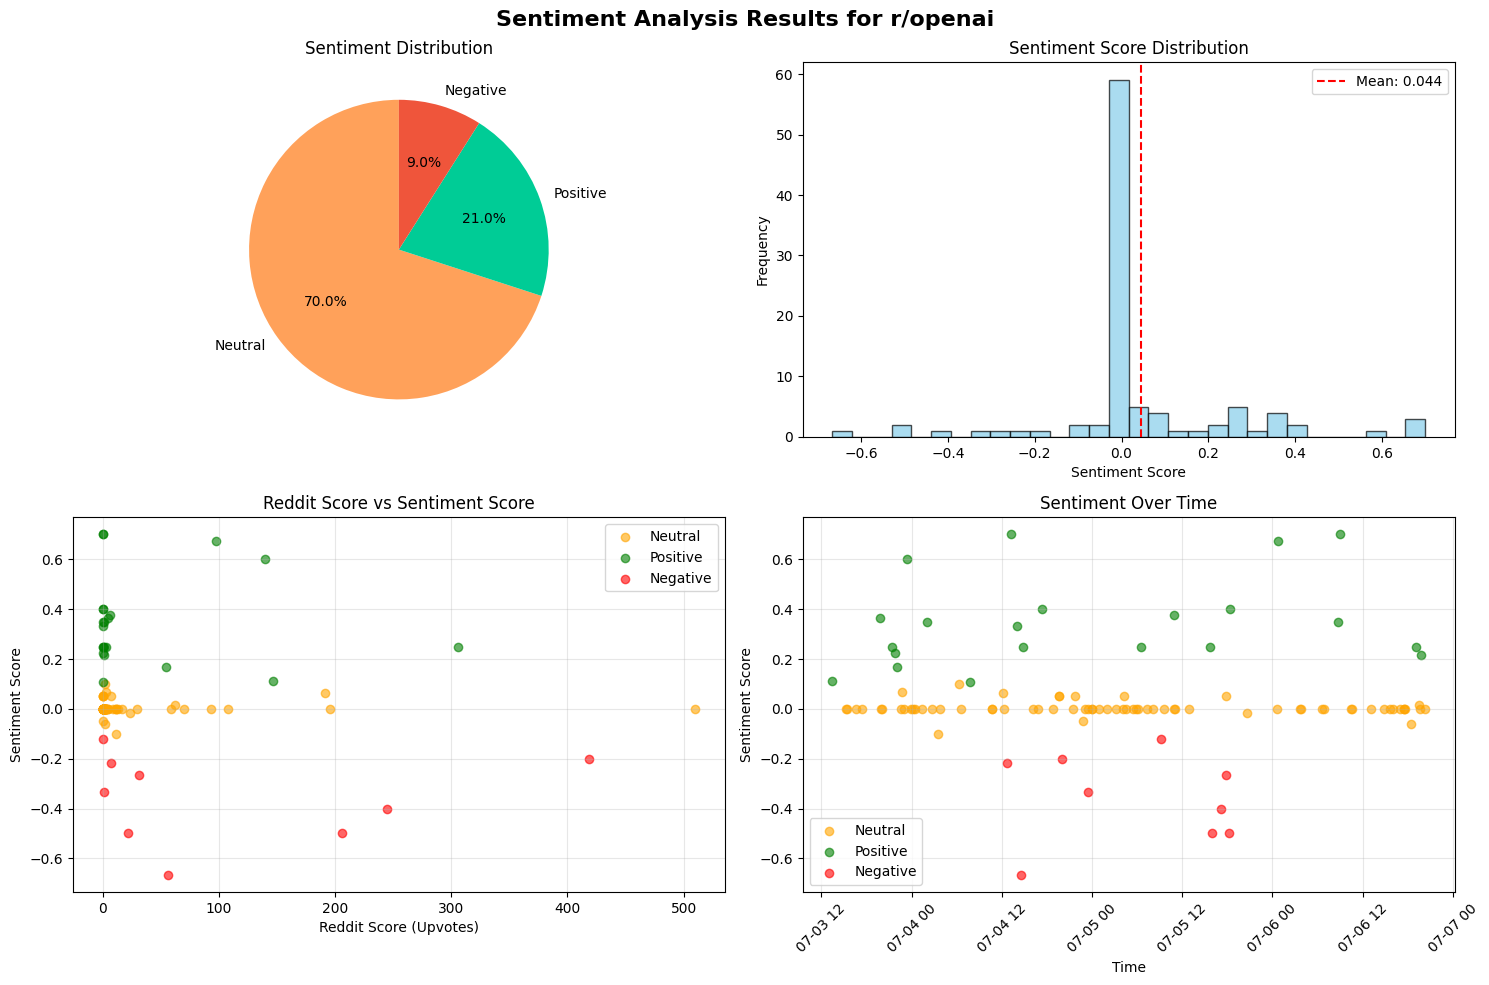

In [58]:
# Visualizations
if not df.empty:
    # Set up the plotting style
    plt.rcParams['figure.figsize'] = (15, 10)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Sentiment Analysis Results for r/{ANALYSIS_CONFIG["subreddit"]}', fontsize=16, fontweight='bold')
    
    # 1. Sentiment Distribution (Pie Chart)
    sentiment_counts = df['sentiment'].value_counts()
    colors = {'Positive': '#00CC96', 'Negative': '#EF553B', 'Neutral': '#FFA15A'}
    pie_colors = [colors.get(sentiment, '#636EFA') for sentiment in sentiment_counts.index]
    
    axes[0,0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
                  colors=pie_colors, startangle=90)
    axes[0,0].set_title('Sentiment Distribution')
    
    # 2. Sentiment Score Distribution
    axes[0,1].hist(df['sentiment_score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,1].set_title('Sentiment Score Distribution')
    axes[0,1].set_xlabel('Sentiment Score')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(df['sentiment_score'].mean(), color='red', linestyle='--', label=f'Mean: {df["sentiment_score"].mean():.3f}')
    axes[0,1].legend()
    
    # 3. Sentiment vs Reddit Score
    sentiment_color_map = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'orange'}
    for sentiment in df['sentiment'].unique():
        sentiment_data = df[df['sentiment'] == sentiment]
        axes[1,0].scatter(sentiment_data['score'], sentiment_data['sentiment_score'], 
                         label=sentiment, color=sentiment_color_map.get(sentiment, 'blue'), alpha=0.6)
    
    axes[1,0].set_title('Reddit Score vs Sentiment Score')
    axes[1,0].set_xlabel('Reddit Score (Upvotes)')
    axes[1,0].set_ylabel('Sentiment Score')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Sentiment Over Time
    df_sorted = df.sort_values('created_utc')
    for sentiment in df['sentiment'].unique():
        sentiment_data = df_sorted[df_sorted['sentiment'] == sentiment]
        axes[1,1].scatter(sentiment_data['created_utc'], sentiment_data['sentiment_score'], 
                         label=sentiment, color=sentiment_color_map.get(sentiment, 'blue'), alpha=0.6)
    
    axes[1,1].set_title('Sentiment Over Time')
    axes[1,1].set_xlabel('Time')
    axes[1,1].set_ylabel('Sentiment Score')
    axes[1,1].legend()
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Step 8: Word Clouds

What a Word Cloud Does: 

1. **Combines text**: Merges all positive posts into one big string
2. **Generates cloud**: Creates visual representation where bigger words appear more frequently
3. **Side-by-side**: Shows positive words vs negative words
4. **Business value**: Help businesses / individuals quickly identify what topics drive positive vs negative sentiment

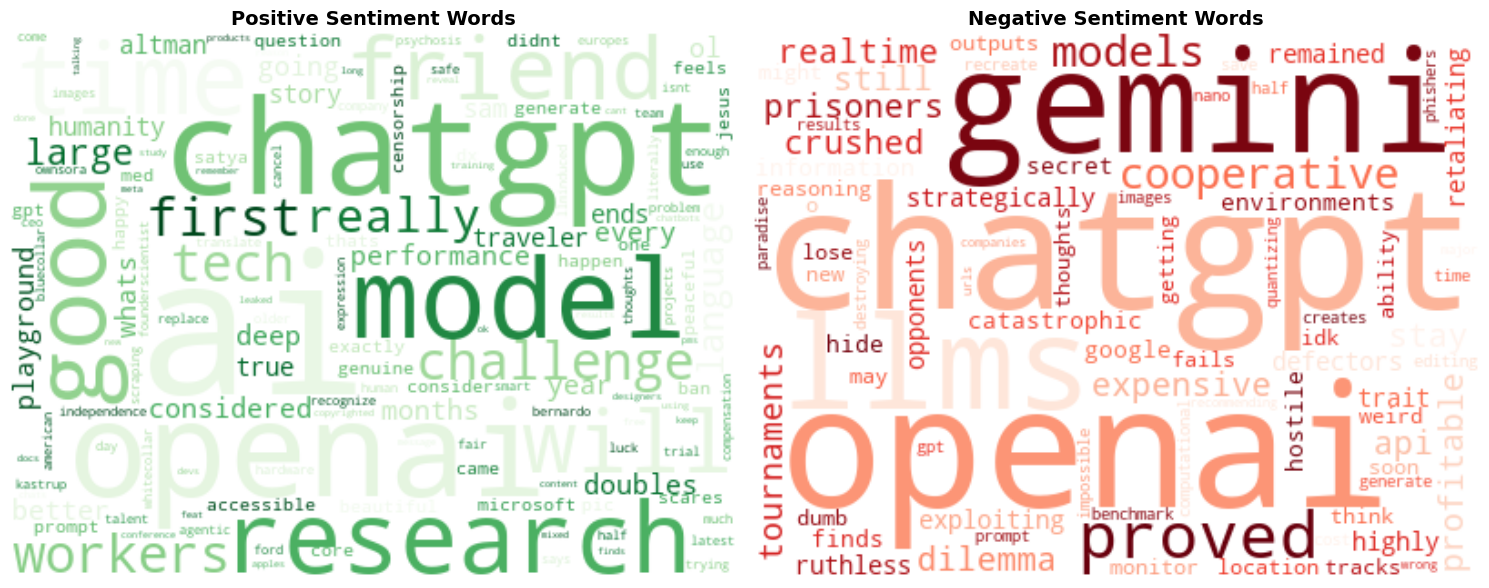

In [59]:
# Word Clouds
if not df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Positive word cloud
    positive_text = ' '.join(df[df['sentiment'] == 'Positive']['clean_title'])
    if positive_text:
        wordcloud_pos = WordCloud(width=400, height=300, background_color='white', 
                                 colormap='Greens').generate(positive_text)
        axes[0].imshow(wordcloud_pos, interpolation='bilinear')
        axes[0].set_title('Positive Sentiment Words', fontsize=14, fontweight='bold')
        axes[0].axis('off')
    
    # Negative word cloud
    negative_text = ' '.join(df[df['sentiment'] == 'Negative']['clean_title'])
    if negative_text:
        wordcloud_neg = WordCloud(width=400, height=300, background_color='white', 
                                 colormap='Reds').generate(negative_text)
        axes[1].imshow(wordcloud_neg, interpolation='bilinear')
        axes[1].set_title('Negative Sentiment Words', fontsize=14, fontweight='bold')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

## Step 9: Detailed Analysis 

In this step, we do the following: 

1. View the top 3 most positive posts with scores and titles
2. View the top 3 most negative posts with scores and titles
3. Export the CSV with timestamp for record keeping

Thus, we get concrete examples for reporting, create a permanent record of the analysis, and show specific content that drives sentiment.

In [60]:
# Detailed Analysis and Top Posts
if not df.empty:
    print("🏆 TOP POSITIVE POSTS:")
    print("=" * 50)
    top_positive = df[df['sentiment'] == 'Positive'].nlargest(3, 'sentiment_score')
    for i, (_, post) in enumerate(top_positive.iterrows(), 1):
        print(f"{i}. Score: {post['sentiment_score']:.3f} | Reddit Score: {post['score']}")
        print(f"   Title: {post['title'][:100]}...")
        print()
    
    print("💔 TOP NEGATIVE POSTS:")
    print("=" * 50)
    top_negative = df[df['sentiment'] == 'Negative'].nsmallest(3, 'sentiment_score')
    for i, (_, post) in enumerate(top_negative.iterrows(), 1):
        print(f"{i}. Score: {post['sentiment_score']:.3f} | Reddit Score: {post['score']}")
        print(f"   Title: {post['title'][:100]}...")
        print()
    
    # Save results
    output_filename = f"reddit_sentiment_{ANALYSIS_CONFIG['subreddit']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df.to_csv(output_filename, index=False)
    print(f"Results saved to: {output_filename}")

🏆 TOP POSITIVE POSTS:
1. Score: 0.700 | Reddit Score: 0
   Title: What’s going to be considered ‘the good ol’ times’ the year before humanity ends?...

2. Score: 0.700 | Reddit Score: 0
   Title: Trying to cancel ChatGPT Team trial? Good luck......

3. Score: 0.675 | Reddit Score: 98
   Title: Generate a pic that you consider the most beautiful...

💔 TOP NEGATIVE POSTS:
1. Score: -0.667 | Reddit Score: 56
   Title: It's impossible to recreate OpenAI GPT 4.1-nano benchmark results...

2. Score: -0.500 | Reddit Score: 22
   Title: Realtime API is still too expensive, how do you stay profitable?...

3. Score: -0.500 | Reddit Score: 206
   Title: It's getting weird....

Results saved to: reddit_sentiment_openai_20250706_210947.csv


## Step 10: Interactive Visualizations 

**Key Features -**

* **Interactive**: Can hover, zoom, click on chart elements
* **Professional**: Plotly creates publication-quality charts
* **Hover data**: Shows post titles when hovering over points

This is perfect for presentations and demos.

In [63]:
# Interactive Plotly Visualizations

if not df.empty:
    # Interactive sentiment distribution
    fig_pie = px.pie(
        values=sentiment_counts.values,
        names=sentiment_counts.index,
        title="Interactive Sentiment Distribution",
        color_discrete_map={'Positive': '#00CC96', 'Negative': '#EF553B', 'Neutral': '#FFA15A'}
    )
    fig_pie.show()
    
    # Interactive scatter plot
    fig_scatter = px.scatter(
        df, 
        x='score', 
        y='sentiment_score',
        color='sentiment',
        title="Interactive: Post Score vs Sentiment Score",
        hover_data=['title'],
        color_discrete_map={'Positive': '#00CC96', 'Negative': '#EF553B', 'Neutral': '#FFA15A'}
    )
    fig_scatter.show()